# Analysis

## Setup

In [35]:
d = read.csv("../data/wiki/user_data.csv", header = TRUE)
library(lsr)
head(d)

user_id,edit_count,gender,admin_ascention,admin,eigen_central,eigen_central_bin,community,coord_given_all,coord_received_all,coord_given_ingroup,coord_received_ingroup,post_count,italics_freq,bold_freq,link_freq,function_words_freq,avg_length_tokens
K-F.U.N 2,165,male,,False,3.761916e-07,False,0,NaN,NaN,NA,NA,1,NA,NA,NA,NA,1.000000
JFreeman,9270,unknown,,False,1.671275e-03,False,1,NaN,0.00000,NA,NA,1,NA,NA,NA,28.00000,4.000000
Extcetc,27,unknown,,False,4.017304e-06,False,2,NaN,0.00000,NA,NA,1,NA,NA,NA,4.00000,2.000000
Merteselle,295,unknown,,False,4.261994e-08,False,3,NaN,0.00000,NA,NA,1,NA,NA,NA,2.00000,2.000000
The Sunshine Man,0,unknown,,False,6.056635e-07,False,9,0.00000000,0.00000,NA,NA,3,NA,NA,NA,27.33333,3.333333
Kuebie,1607,unknown,,False,5.176361e-05,False,5,0.08333333,0.11875,NA,NA,9,NA,NA,0.1111111,23.77778,4.000000


In [36]:
# d <- subset(d, eigen_central < 0.6) # eliminates 2 outliers
d.admin <- subset(d, admin == "True")
d.nonadmin <- subset(d, admin == "False")
d.higheigen <- subset(d, eigen_central_bin == "True")
d.loweigen <- subset(d, eigen_central_bin == "False")

In [44]:
d.higheigen.admin <- subset(d, eigen_central_bin == "True" & admin == "True")
d.higheigen.nonadmin <- subset(d, eigen_central_bin == "True" & admin == "False")
d.loweigen.admin <- subset(d, eigen_central_bin == "False" & admin == "True")
d.loweigen.nonadmin <- subset(d, eigen_central_bin == "False" & admin == "False")

# nrow(d.loweigen.admin) # 1703
# nrow(d.higheigen.admin) # 77
# nrow(d.higheigen.nonadmin) # 120
# nrow(d.loweigen.nonadmin) # 20197

## Replicating *Centre Stage* results

Relationship between power (adminship & centrality) and coordination.

In [38]:
# Coordination received vs. eigenvector centrality
cor.test(d$eigen_central, d$coord_received_all, alternative="greater", method="spearman", exact = FALSE)


	Spearman's rank correlation rho

data:  d$eigen_central and d$coord_received_all
S = 8.921e+11, p-value < 2.2e-16
alternative hypothesis: true rho is greater than 0
sample estimates:
      rho 
0.1898093 


In [48]:
# Do highgly central and non-central users receive different amounts of coordination? YES
t.test(d.loweigen$coord_received_all, d.higheigen$coord_received_all)
cohensD(d.loweigen$coord_received_all, d.higheigen$coord_received_all)
# Do admins and non-admins receive different amounts of coordination? YES
t.test(d.nonadmin$coord_received_all, d.admin$coord_received_all)
cohensD(d.nonadmin$coord_received_all, d.admin$coord_received_all)
# Do hihgly central users and admins receive different amounts of coordination? NO
t.test(d.higheigen$coord_received_all, d.admin$coord_received_all)
cohensD(d.higheigen$coord_received_all, d.admin$coord_received_all)


	Welch Two Sample t-test

data:  d.loweigen$coord_received_all and d.higheigen$coord_received_all
t = -6.0555, df = 216.1, p-value = 6.128e-09
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.018467269 -0.009397584
sample estimates:
 mean of x  mean of y 
0.00776210 0.02169453 


[1] 0.1993865


	Welch Two Sample t-test

data:  d.nonadmin$coord_received_all and d.admin$coord_received_all
t = -8.6984, df = 2157.4, p-value < 2.2e-16
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.01729538 -0.01093159
sample estimates:
 mean of x  mean of y 
0.00487270 0.01898618 


[1] 0.2038402


	Welch Two Sample t-test

data:  d.higheigen$coord_received_all and d.admin$coord_received_all
t = 0.99532, df = 412.59, p-value = 0.3202
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.002640557  0.008057243
sample estimates:
 mean of x  mean of y 
0.02169453 0.01898618 


[1] 0.04357806

In [47]:
# This is what we had tested in Centre Stage:
# among highy central, do admins receive more coordination? NO
t.test(d.higheigen.admin$coord_received_all, d.higheigen.nonadmin$coord_received_all)
cohensD(d.higheigen.admin$coord_received_all, d.higheigen.nonadmin$coord_received_all)
# among non-central users, do admins receive more coordination? YES
t.test(d.loweigen.admin$coord_received_all, d.loweigen.nonadmin$coord_received_all)
cohensD(d.loweigen.admin$coord_received_all, d.loweigen.nonadmin$coord_received_all)


	Welch Two Sample t-test

data:  d.higheigen.admin$coord_received_all and d.higheigen.nonadmin$coord_received_all
t = 0.41469, df = 193.98, p-value = 0.6788
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.006545371  0.010030609
sample estimates:
 mean of x  mean of y 
0.02275255 0.02100993 


[1] 0.05538634


	Welch Two Sample t-test

data:  d.loweigen.admin$coord_received_all and d.loweigen.nonadmin$coord_received_all
t = 7.273, df = 2052.8, p-value = 4.977e-13
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 0.009080248 0.015785003
sample estimates:
  mean of x   mean of y 
0.019080557 0.006647931 


[1] 0.1774044

In [49]:
# We had not tested this counterpart, however: 
# among admins, do highly central users receive more coordination? NO
t.test(d.loweigen.admin$coord_received_all, d.higheigen.admin$coord_received_all)
cohensD(d.loweigen.admin$coord_received_all, d.higheigen.admin$coord_received_all)
# among non-admins, do highly central users receive more coordination? YES
t.test(d.loweigen.nonadmin$coord_received_all, d.higheigen.nonadmin$coord_received_all)
cohensD(d.loweigen.nonadmin$coord_received_all, d.higheigen.nonadmin$coord_received_all)


	Welch Two Sample t-test

data:  d.loweigen.admin$coord_received_all and d.higheigen.admin$coord_received_all
t = -1.1941, df = 144.79, p-value = 0.2344
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.009750026  0.002406049
sample estimates:
 mean of x  mean of y 
0.01908056 0.02275255 


[1] 0.05662251


	Welch Two Sample t-test

data:  d.loweigen.nonadmin$coord_received_all and d.higheigen.nonadmin$coord_received_all
t = -4.306, df = 124.49, p-value = 3.336e-05
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.020963288 -0.007760703
sample estimates:
  mean of x   mean of y 
0.006647931 0.021009926 


[1] 0.2043657

-  Weak positive correlation between coordination received and centrality: r = 1.9 p < 0.001
-  More coordination received by highly central than low central (p < 0.001, d=0.2)
-  More coodination received by admins than non-admins (p < 0.001, d=0.18)
-  The amount of coordination received by admins vs highly central users is not significantly different.
-  Among highly central users, there is no significant effect of adminship
-  Among admins, there is no significant effect of centrality


## Ingroup / outgroup coordination

In [53]:
# Is there more coordination towards users in own sub-group? NO
t.test(d$coord_given_all, d$coord_given_ingroup)
t.test(d.higheigen$coord_given_all, d.higheigen$coord_given_ingroup)
t.test(d.loweigen$coord_given_all, d.loweigen$coord_given_ingroup)
t.test(d.admin$coord_given_all, d.admin$coord_given_ingroup)
t.test(d.nonadmin$coord_given_all, d.nonadmin$coord_given_ingroup)


	Welch Two Sample t-test

data:  d$coord_given_all and d$coord_given_ingroup
t = -1.0902, df = 343.58, p-value = 0.2764
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.01283783  0.00368176
sample estimates:
  mean of x   mean of y 
0.005561945 0.010139981 



	Welch Two Sample t-test

data:  d.higheigen$coord_given_all and d.higheigen$coord_given_ingroup
t = 1.671, df = 2.0825, p-value = 0.2317
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.03706352  0.08716706
sample estimates:
   mean of x    mean of y 
 0.017393882 -0.007657888 



	Welch Two Sample t-test

data:  d.loweigen$coord_given_all and d.loweigen$coord_given_ingroup
t = -0.5777, df = 341.98, p-value = 0.5638
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.010788400  0.005889869
sample estimates:
  mean of x   mean of y 
0.007852026 0.010301291 



	Welch Two Sample t-test

data:  d.admin$coord_given_all and d.admin$coord_given_ingroup
t = -0.5154, df = 42.738, p-value = 0.6089
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.02208988  0.01309850
sample estimates:
 mean of x  mean of y 
0.01726510 0.02176079 



	Welch Two Sample t-test

data:  d.nonadmin$coord_given_all and d.nonadmin$coord_given_ingroup
t = -0.94124, df = 299.89, p-value = 0.3473
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.013476155  0.004755876
sample estimates:
  mean of x   mean of y 
0.004108355 0.008468495 


In [55]:
# Is there more correlation received by users within own sub-group? NO
t.test(d$coord_received_all, d$coord_received_ingroup)
t.test(d.higheigen$coord_received_all, d.higheigen$coord_received_ingroup)
t.test(d.loweigen$coord_received_all, d.loweigen$coord_received_ingroup)
t.test(d.admin$coord_received_all, d.admin$coord_received_ingroup)
t.test(d.nonadmin$coord_received_all, d.nonadmin$coord_received_ingroup)


	Welch Two Sample t-test

data:  d$coord_received_all and d$coord_received_ingroup
t = 0.90586, df = 542.45, p-value = 0.3654
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.002468075  0.006692489
sample estimates:
  mean of x   mean of y 
0.006075535 0.003963327 



	Welch Two Sample t-test

data:  d.higheigen$coord_received_all and d.higheigen$coord_received_ingroup
t = 1.0836, df = 2.2538, p-value = 0.3807
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.02594280  0.04611883
sample estimates:
 mean of x  mean of y 
0.02169453 0.01160651 



	Welch Two Sample t-test

data:  d.loweigen$coord_received_all and d.loweigen$coord_received_ingroup
t = 1.6351, df = 544.98, p-value = 0.1026
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.0007741044  0.0084642945
sample estimates:
  mean of x   mean of y 
0.007762100 0.003917005 



	Welch Two Sample t-test

data:  d.admin$coord_received_all and d.admin$coord_received_ingroup
t = 0.38208, df = 48.467, p-value = 0.7041
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.01314462  0.01931425
sample estimates:
 mean of x  mean of y 
0.01898618 0.01590136 



	Welch Two Sample t-test

data:  d.nonadmin$coord_received_all and d.nonadmin$coord_received_ingroup
t = 0.87442, df = 492.94, p-value = 0.3823
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.002648931  0.006897543
sample estimates:
  mean of x   mean of y 
0.004872700 0.002748394 


# Social power & linguistic style

In [60]:
# Correlation between centrality and linguistic style features
cor.test(d$eigen_central, d$avg_length_tokens, alternative="greater", method="spearman", exact = FALSE)
cor.test(d$eigen_central, d$italics_freq, alternative="less", method="spearman", exact = FALSE)
cor.test(d$eigen_central, d$bold_freq, alternative="less", method="spearman", exact = FALSE)
cor.test(d$eigen_central, d$link_freq, alternative="less", method="spearman", exact = FALSE)

## Slight positive correlation with post length
## Clear negative correlations for italics, bold and links


	Spearman's rank correlation rho

data:  d$eigen_central and d$avg_length_tokens
S = 1.5664e+12, p-value < 2.2e-16
alternative hypothesis: true rho is greater than 0
sample estimates:
      rho 
0.1289431 



	Spearman's rank correlation rho

data:  d$eigen_central and d$italics_freq
S = 7.5475e+10, p-value < 2.2e-16
alternative hypothesis: true rho is less than 0
sample estimates:
       rho 
-0.4922603 



	Spearman's rank correlation rho

data:  d$eigen_central and d$bold_freq
S = 10070000, p-value < 2.2e-16
alternative hypothesis: true rho is less than 0
sample estimates:
       rho 
-0.6660672 



	Spearman's rank correlation rho

data:  d$eigen_central and d$link_freq
S = 130800000, p-value < 2.2e-16
alternative hypothesis: true rho is less than 0
sample estimates:
       rho 
-0.7123572 


In [56]:
# Length of posts: 
t.test(d.admin$avg_length_tokens, d.nonadmin$avg_length_tokens)
cat("effect size (Cohen's d): ", cohensD(d.admin$avg_length_tokens, d.nonadmin$avg_length_tokens))
t.test(d.higheigen$avg_length_tokens, d.loweigen$avg_length_tokens)
cat("Effect size (Cohen's d): ", cohensD(d.higheigen$avg_length_tokens, d.loweigen$avg_length_tokens))


	Welch Two Sample t-test

data:  d.admin$avg_length_tokens and d.nonadmin$avg_length_tokens
t = 5.7325, df = 2998.1, p-value = 1.088e-08
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 0.09953836 0.20302950
sample estimates:
mean of x mean of y 
 3.228846  3.077562 


effect size (Cohen's d):  0.0801157


	Welch Two Sample t-test

data:  d.higheigen$avg_length_tokens and d.loweigen$avg_length_tokens
t = 3.6608, df = 206.98, p-value = 0.0003192
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 0.1299045 0.4331084
sample estimates:
mean of x mean of y 
 3.366401  3.084895 


Effect size (Cohen's d):  0.1513009


	Spearman's rank correlation rho

data:  d$eigen_central and d$avg_length_tokens
S = 1.5664e+12, p-value < 2.2e-16
alternative hypothesis: true rho is greater than 0
sample estimates:
      rho 
0.1289431 


In [21]:
# Use of italics
t.test(d.admin$italics_freq, d.nonadmin$italics_freq)
cat("effect size (Cohen's d): ", cohensD(d.admin$italics_freq, d.nonadmin$italics_freq))
t.test(d.higheigen$italics_freq, d.loweigen$italics_freq)
cat("effect size (Cohen's d): ", cohensD(d.higheigen$italics_freq, d.loweigen$italics_freq))


	Welch Two Sample t-test

data:  d.admin$italics_freq and d.nonadmin$italics_freq
t = -27.07, df = 3130.7, p-value < 2.2e-16
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.1722308 -0.1489658
sample estimates:
mean of x mean of y 
0.1459422 0.3065405 


effect size (Cohen's d):  0.5889673


	Welch Two Sample t-test

data:  d.higheigen$italics_freq and d.loweigen$italics_freq
t = -15.736, df = 226.93, p-value < 2.2e-16
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.1691757 -0.1315231
sample estimates:
mean of x mean of y 
0.1132400 0.2635894 


effect size (Cohen's d):  0.5627454

In [18]:
# Use of boldface
t.test(d.admin$bold_freq, d.nonadmin$bold_freq)
cat("effect size (Cohen's d): ", cohensD(d.admin$bold_freq, d.nonadmin$bold_freq))
t.test(d.higheigen$bold_freq, d.loweigen$bold_freq)
cat("effect size (Cohen's d): ", cohensD(d.higheigen$bold_freq, d.loweigen$bold_freq))


	Welch Two Sample t-test

data:  d.admin$bold_freq and d.nonadmin$bold_freq
t = -2.7144, df = 168.98, p-value = 0.007329
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.13496216 -0.02130944
sample estimates:
mean of x mean of y 
0.1026712 0.1808070 


effect size (Cohen's d):  0.3002008


	Welch Two Sample t-test

data:  d.higheigen$bold_freq and d.loweigen$bold_freq
t = -9.3721, df = 301.14, p-value < 2.2e-16
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.1809507 -0.1181483
sample estimates:
 mean of x  mean of y 
0.01554881 0.16509832 


effect size (Cohen's d):  0.5863562

In [22]:
# Use of links
t.test(d.admin$link_freq, d.nonadmin$link_freq)
cat("effect size (Cohen's d): ", cohensD(d.admin$link_freq, d.nonadmin$link_freq))
t.test(d.higheigen$link_freq, d.loweigen$link_freq)
cat("effect size (Cohen's d): ", cohensD(d.higheigen$link_freq, d.loweigen$link_freq))


	Welch Two Sample t-test

data:  d.admin$link_freq and d.nonadmin$link_freq
t = -9.6584, df = 800, p-value < 2.2e-16
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.12999727 -0.08608217
sample estimates:
 mean of x  mean of y 
0.03408172 0.14212144 


effect size (Cohen's d):  0.5239327


	Welch Two Sample t-test

data:  d.higheigen$link_freq and d.loweigen$link_freq
t = -10.81, df = 697.03, p-value < 2.2e-16
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.10907081 -0.07554059
sample estimates:
 mean of x  mean of y 
0.01707753 0.10938323 


effect size (Cohen's d):  0.4594793

### Interim summary
 
-  admins and highly-central users tend to post longer messages (p < 0.001, but low effect size: 0.08 and 0.15 for admins and highly central, respectively). There is a weak positive correlation between centrality and post length
-  admins and highly-central users use significantly fewer italics, boldface, and URLs in their posts than non-admins and non-highly-central users (p < 0.001, strong effect size of around 0.5 in all cases). There are clear negative correlations between centrality and use of italics, boldface, and links.


In [25]:
# Is there a difference in the length of posts by admins and highly central users?
t.test(d.admin$avg_length_tokens, d.higheigen$avg_length_tokens)
cat("effect size (Cohen's d): ", cohensD(d.admin$avg_length_tokens, d.higheigen$avg_length_tokens))


	Welch Two Sample t-test

data:  d.admin$avg_length_tokens and d.higheigen$avg_length_tokens
t = -1.7337, df = 234.37, p-value = 0.08429
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.29387110  0.01876064
sample estimates:
mean of x mean of y 
 3.228846  3.366401 


effect size (Cohen's d):  0.1375377

In [20]:
# Is there a difference in the freq of use of links by admins and highly central users?
t.test(d.admin$link_freq, d.higheigen$link_freq)
cat("effect size (Cohen's d): ", cohensD(d.admin$link_freq, d.higheigen$link_freq))


	Welch Two Sample t-test

data:  d.admin$link_freq and d.higheigen$link_freq
t = 2.5976, df = 264.74, p-value = 0.009914
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 0.004115007 0.029893377
sample estimates:
 mean of x  mean of y 
0.03408172 0.01707753 


effect size (Cohen's d):  0.2322502

In [23]:
# Is there a difference in the freq of use of italics by admins and highly central users?
t.test(d.admin$italics_freq, d.higheigen$italics_freq)
cat("effect size (Cohen's d): ", cohensD(d.admin$italics_freq, d.higheigen$italics_freq))


	Welch Two Sample t-test

data:  d.admin$italics_freq and d.higheigen$italics_freq
t = 3.2498, df = 276.65, p-value = 0.001298
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 0.01289283 0.05251158
sample estimates:
mean of x mean of y 
0.1459422 0.1132400 


effect size (Cohen's d):  0.2088582

In [24]:
# Is there a difference in the freq of use of boldface by admins and highly central users?
t.test(d.admin$bold_freq, d.higheigen$bold_freq)
cat("effect size (Cohen's d): ", cohensD(d.admin$bold_freq, d.higheigen$bold_freq))


	Welch Two Sample t-test

data:  d.admin$bold_freq and d.higheigen$bold_freq
t = 3.6533, df = 85.41, p-value = 0.0004458
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 0.03971077 0.13453396
sample estimates:
 mean of x  mean of y 
0.10267118 0.01554881 


effect size (Cohen's d):  0.4748779

In [27]:
# Admins vs non-admins within the class of highly central users

# post length: 
t.test(d.higheigen.admin$avg_length_tokens, d.higheigen.nonadmin$avg_length_tokens)
cat("effect size (Cohen's d): ", cohensD(d.higheigen.admin$avg_length_tokens, d.higheigen.nonadmin$avg_length_tokens))
# itlaics
t.test(d.higheigen.admin$italics_freq, d.higheigen.nonadmin$italics_freq)
cat("effect size (Cohen's d): ", cohensD(d.higheigen.admin$italics_freq, d.higheigen.nonadmin$italics_freq))
# boldface
t.test(d.higheigen.admin$bold_freq, d.higheigen.nonadmin$bold_freq)
cat("effect size (Cohen's d): ", cohensD(d.higheigen.admin$bold_freq, d.higheigen.nonadmin$bold_freq))
# links
t.test(d.higheigen.admin$link_freq, d.higheigen.nonadmin$link_freq)
cat("effect size (Cohen's d): ", cohensD(d.higheigen.admin$link_freq, d.higheigen.nonadmin$link_freq))


	Welch Two Sample t-test

data:  d.higheigen.admin$avg_length_tokens and d.higheigen.nonadmin$avg_length_tokens
t = -0.26241, df = 176.22, p-value = 0.7933
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.3391544  0.2595465
sample estimates:
mean of x mean of y 
 3.342155  3.381959 


effect size (Cohen's d):  0.03729621

In [32]:
# Admins vs non-admins within the class of low centrality users

# post length: 
t.test(d.loweigen.admin$avg_length_tokens, d.loweigen.nonadmin$avg_length_tokens)
cat("effect size (Cohen's d): ", cohensD(d.loweigen.admin$avg_length_tokens, d.loweigen.nonadmin$avg_length_tokens))
# italics
t.test(d.loweigen.admin$italics_freq, d.loweigen.nonadmin$italics_freq)
cat("effect size (Cohen's d): ", cohensD(d.loweigen.admin$italics_freq, d.loweigen.nonadmin$italics_freq))
# boldface
t.test(d.loweigen.admin$bold_freq, d.loweigen.nonadmin$bold_freq)
cat("effect size (Cohen's d): ", cohensD(d.loweigen.admin$bold_freq, d.loweigen.nonadmin$bold_freq))
# links
t.test(d.loweigen.admin$link_freq, d.loweigen.nonadmin$link_freq)
cat("effect size (Cohen's d): ", cohensD(d.loweigen.admin$link_freq, d.loweigen.nonadmin$link_freq))


	Welch Two Sample t-test

data:  d.loweigen.admin$avg_length_tokens and d.loweigen.nonadmin$avg_length_tokens
t = 5.7818, df = 2988.5, p-value = 8.156e-09
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 0.1036142 0.2099539
sample estimates:
mean of x mean of y 
 3.229487  3.072703 


effect size (Cohen's d):  0.08403338

In [61]:
# High vs. low centrality with the class of admins

# post length: 
t.test(d.higheigen.admin$avg_length_tokens, d.loweigen.admin$avg_length_tokens)
cat("effect size (Cohen's d): ", cohensD(d.higheigen.admin$avg_length_tokens, d.higheigen.nonadmin$avg_length_tokens))
# itlaics
t.test(d.higheigen.admin$italics_freq, d.loweigen.admin$italics_freq)
cat("effect size (Cohen's d): ", cohensD(d.higheigen.admin$italics_freq, d.higheigen.nonadmin$italics_freq))
# boldface
t.test(d.higheigen.admin$bold_freq, d.loweigen.admin$bold_freq)
cat("effect size (Cohen's d): ", cohensD(d.higheigen.admin$bold_freq, d.higheigen.nonadmin$bold_freq))
# links
t.test(d.higheigen.admin$link_freq, d.loweigen.admin$link_freq)
cat("effect size (Cohen's d): ", cohensD(d.higheigen.admin$link_freq, d.higheigen.nonadmin$link_freq))


	Welch Two Sample t-test

data:  d.higheigen.admin$avg_length_tokens and d.loweigen.admin$avg_length_tokens
t = 0.98129, df = 82.786, p-value = 0.3293
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.1157054  0.3410419
sample estimates:
mean of x mean of y 
 3.342155  3.229487 


effect size (Cohen's d):  0.03729621


	Welch Two Sample t-test

data:  d.higheigen.admin$italics_freq and d.loweigen.admin$italics_freq
t = -2.0873, df = 88.439, p-value = 0.03974
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.063129062 -0.001551849
sample estimates:
mean of x mean of y 
0.1110705 0.1434109 


effect size (Cohen's d):  0.03174539


	Welch Two Sample t-test

data:  d.higheigen.admin$bold_freq and d.loweigen.admin$bold_freq
t = -4.026, df = 70.428, p-value = 0.0001412
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.15698771 -0.05298237
sample estimates:
  mean of x   mean of y 
0.009799795 0.114784834 


effect size (Cohen's d):  0.4063322


	Welch Two Sample t-test

data:  d.higheigen.admin$link_freq and d.loweigen.admin$link_freq
t = -2.7284, df = 92.302, p-value = 0.007621
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.040629229 -0.006397743
sample estimates:
 mean of x  mean of y 
0.01332803 0.03684152 


effect size (Cohen's d):  0.247536

In [62]:
# High vs. low centrality with the class of non-admins

# post length: 
t.test(d.loweigen.nonadmin$avg_length_tokens, d.higheigen.nonadmin$avg_length_tokens)
cat("effect size (Cohen's d): ", cohensD(d.loweigen.admin$avg_length_tokens, d.loweigen.nonadmin$avg_length_tokens))
# italics
t.test(d.loweigen.nonadmin$italics_freq, d.higheigen.nonadmin$italics_freq)
cat("effect size (Cohen's d): ", cohensD(d.loweigen.admin$italics_freq, d.loweigen.nonadmin$italics_freq))
# boldface
t.test(d.loweigen.nonadmin$bold_freq, d.higheigen.nonadmin$bold_freq)
cat("effect size (Cohen's d): ", cohensD(d.loweigen.admin$bold_freq, d.loweigen.nonadmin$bold_freq))
# links
t.test(d.loweigen.nonadmin$link_freq, d.higheigen.nonadmin$link_freq)
cat("effect size (Cohen's d): ", cohensD(d.loweigen.admin$link_freq, d.loweigen.nonadmin$link_freq))


	Welch Two Sample t-test

data:  d.loweigen.nonadmin$avg_length_tokens and d.higheigen.nonadmin$avg_length_tokens
t = -3.0094, df = 123.23, p-value = 0.003175
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.5126681 -0.1058444
sample estimates:
mean of x mean of y 
 3.072703  3.381959 


effect size (Cohen's d):  0.08403338


	Welch Two Sample t-test

data:  d.loweigen.nonadmin$italics_freq and d.higheigen.nonadmin$italics_freq
t = 14.807, df = 125.25, p-value < 2.2e-16
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 0.1509379 0.1975128
sample estimates:
mean of x mean of y 
0.2890764 0.1148510 


effect size (Cohen's d):  0.5511166


	Welch Two Sample t-test

data:  d.loweigen.nonadmin$bold_freq and d.higheigen.nonadmin$bold_freq
t = 7.8707, df = 120.05, p-value = 1.745e-12
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 0.1191460 0.1992367
sample estimates:
 mean of x  mean of y 
0.17944390 0.02025255 


effect size (Cohen's d):  0.2470612


	Welch Two Sample t-test

data:  d.loweigen.nonadmin$link_freq and d.higheigen.nonadmin$link_freq
t = 10.574, df = 502.7, p-value < 2.2e-16
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 0.09410137 0.13704891
sample estimates:
 mean of x  mean of y 
0.13540965 0.01983451 


effect size (Cohen's d):  0.4823341

### Interim summary

-  the posts of highly-central users are not significantly longer than those of admins
-  but highly-central users use fewer URLs, italics, and boldface than admins (p < 0.001, effect size between 0.2 and 0.4)
-  within the class of users with low centrality, the effect of adminship is present (admins use fewer italics, boldface, and links: p < 0.05, with effects between 0.2 and 0.5)
-  similarly, among non-admins the effect of centrality is present.
-  However, while within the class of highly-central users, adminship does not have an effect (p > 0.05 for all linguistic style features: length, italics, bold, links), among admins, highly-central users use significantly fewer italics, boldface, and links


In [4]:
d = read.csv("../data/wiki/post_data.csv", header = TRUE)
library(lsr)
head(d)

post_id,len,ppl,align
133333,97,119.50681,False
84731,21,124.71792,False
322884,108,101.49397,False
571787,8,72.47687,False
447384,90,186.39669,False
233202,4,31.89114,False


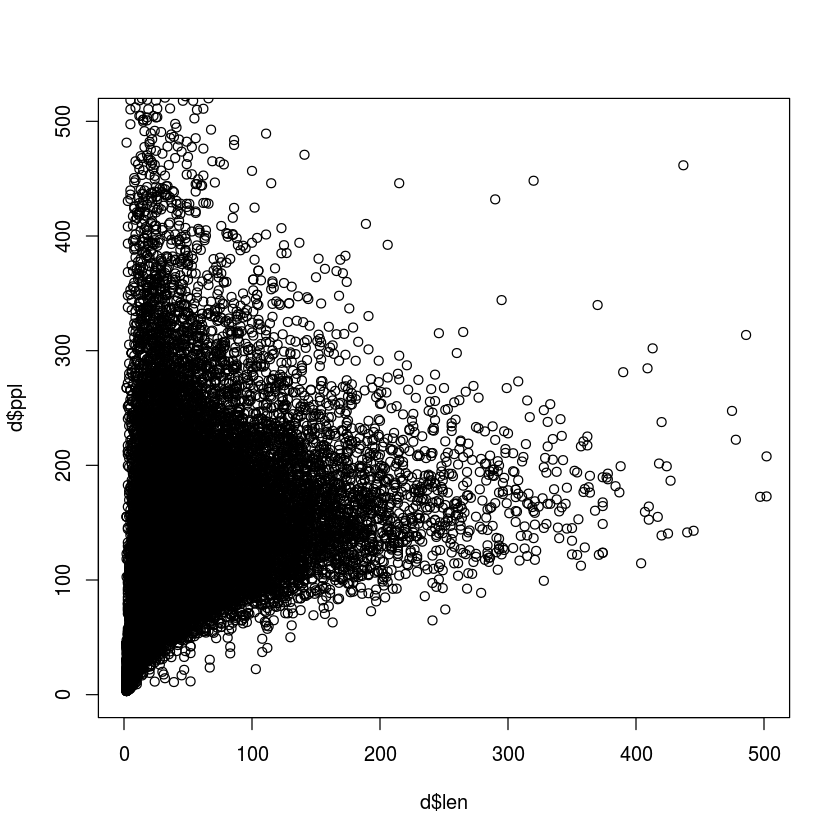

In [3]:
plot(d$len, d$ppl, ylim=c(0,500), xlim=c(0,500))

In [10]:
d.alignedto <- subset(d, align == "True")
d.notalignedto <- subset(d, align == "False")

In [11]:
t.test(d.alignedto$ppl, d.notalignedto$ppl)
cohensD(d.alignedto$ppl, d.notalignedto$ppl)

ERROR: Error in t.test.default(d.alignedto$ppl, d.notalignedto$ppl): not enough 'x' observations


In [12]:
head(d.notalignedto)

post_id,len,ppl,align
133333,97,119.50681,False
84731,21,124.71792,False
322884,108,101.49397,False
571787,8,72.47687,False
447384,90,186.39669,False
233202,4,31.89114,False
